In [73]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import PeHeat_Functions as peh
import parametric_fz as fzpar
import dust_size_dist as sizedist

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import MCMCFit as mcmc

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

In [74]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

In [75]:
# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
#data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

yt : [INFO     ] 2018-10-15 19:36:21,829 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-10-15 19:36:21,842 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-15 19:36:21,843 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-15 19:36:21,844 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-15 19:36:21,845 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-10-15 19:36:21,862 Parameters: current_time              = 568049127341766.1
yt : [INFO     ] 2018-10-15 19:36:21,863 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-10-15 19:36:21,864 Parameters: domain_left_edge          = [-1.974784e+20 -4.936960e+19 -4.936960e+19]
yt : [INFO     ] 2018-10-15 19:36:21,865 Parameters: domain_right_edge   

In [77]:
box["cdh2"]

YTArray([0.63094444, 0.63039282, 0.63473658, ..., 0.41748944, 0.41727191,
         0.41461533]) (dimensionless)

In [ ]:
NH2all = np.zeros_like(box["nH"])
G_CR = np.zeros_like(box["nH"])
for ii in range(len(box["nH"])):
    NH2all[ii] = fz.get_NH2(box["cdh2"][ii].value, box["temp"][ii].value)
    G_CR[ii]   = fz.get_G_CR(NH2all[ii])

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  % accuracy, RuntimeWarning)


In [11]:
wnm = ((box["temperature"].in_units("K") > 6.0e3)&(box["temperature"].in_units("K") < 1.0e4)&(box["iha "] > 0.6)&(box["nH"] >= 0.75))
cnm = ((box["temperature"].in_units("K") > 50)   &(box["temperature"].in_units("K") < 70)   &(box["iha "] > 0.6))
cmm = ((box["temperature"].in_units("K") < 50)   &(box["ih2 "] > 0.6) &(box["nH"] <3.0e4))

wnmtrue = np.argwhere(wnm==True)
cnmtrue = np.argwhere(cnm==True)
cmmtrue = np.argwhere(cmm==True)

wnmindex = wnmtrue[0]
#wnmindex = [3626974]
cnmindex = cnmtrue[0]
#cmmindex = cmmtrue[3626974]
cmmindex = [3479445]

In [14]:
indexarr = np.array([wnmindex, cnmindex, cmmindex])

temp= np.array( box["temp"][indexarr])
dd  = np.array( box["dens"][indexarr])
nH  = np.array( box["nH"]  [indexarr])
nH2 = np.array( box["nH2"]  [indexarr])
nC  = np.array( box["nC"]  [indexarr])
ne  = np.array( box["ne"]  [indexarr])
xe  = np.array( box["xe"]  [indexarr])
xHp = np.array( box["xHp"]  [indexarr])
xH2 = np.array( box["xH2"]  [indexarr])
xCp = np.array( box["xCp"]  [indexarr])
Av  = np.array( box["cdto"][indexarr])
fH2shield  = np.array( box["cdh2"][indexarr])
G0 = 1.7
Ntot =  Av * 1.8
7e21

GG = [fz.get_G(Ntot[0], G0=G0), fz.get_G(Ntot[1], G0=G0), fz.get_G(Ntot[2], G0=G0)]

N2 = np.zeros_like(nH2)
for i in range(3):
    N2[i] = fz.get_f2shield(fH2shield[i], temp[i])

zeta_cmm = fz.get_zeta(N2[2])
xe_cmm    = fz.CR_xe(nH[2], xH2[2], zeta=zeta_cmm)

xe[2] = xe_cmm
ne[2] = nH[2]*xe_cmm

for i in range(3):
    G_CR = fz.get_G_CR(N2[i])
    
Gtot = GG + G_CR

In [64]:
def get_Gamma_dotdot_par(asize, G, Z, grain_type):
    """
    Parametric equation of the energy per photoelectron as a function of the grain size, charge, strength of the incident radiation field and charge.
    
    Input parameters:
        asize: Grain size in Angstroms
        G: Scaling of the radiation field in units of Habing field.
        Z: Charge, in units of proton charge.
        grain_type: 'silicate' or 'carbonaceous'
        
    return:
        Gamma_pe^{''} in erg s-1
    """
    
    if grain_type == "silicate":
        Gamma0 = 2.3e-20
        alpha  = 2.39
        zeta   = 2.953042 * (asize / 5.0)**(-1.03848) 
    else:
        
        Gamma0 = 4.06768782673e-20
        alpha  = 2.16393168
        zeta   = 0.9935858817946079 * (asize / 5.0)**(-1.04665779) 
    
    gamma_dotdot_pe = Gamma0 * (asize / 5.0)**(alpha) * (G / 1.7) * np.exp(- zeta * Z)
    
    return gamma_dotdot_pe

$$ \Gamma^{''}_{\mathrm{pe}}(a, Z, G) = \Gamma_0 \mathrm{\; erg \; s^{-1}} \left( \frac{G}{1.7} \right) \left( \frac{a}{5 A} \right)^{\alpha} \mathrm{exp}(-\zeta Z) $$

Silicates
$$ \zeta(a) = 2.95 \, \left(\frac{a}{5 A}\right)^{-1.04}$$

$$ \Gamma_0 = 2.3 \times 10^{-20} $$

Carbonaceous
$$ \Gamma_0 = 4.07 \times 10^{-20} $$

$$ f(Z) = \frac{1}{\sqrt{2\pi \sigma_{Z}^{2}}} \; \mathrm{exp}\left( - \frac{(Z - \langle Z \rangle)^{2}}{2\sigma_{Z}^{2}} \right)$$


In [65]:
def get_Gamma_dot(Gtot, T, ne, grain_size, grain_type):
    # get ffz par
    zcent = fzpar.get_zcent(Gtot, T, ne, grain_type, grain_size)
    zwidth = fzpar.get_zwidth(grain_size, grain_type, zcent)
    
    zmin = np.floor(zcent - 5*zwidth)
    zmax = np.ceil(zcent + 5*zwidth)
    
    ZZ = np.arange(zmin, zmax+1)
    
    # Assume a Gaussian distribution for the shape of the charge distribution.
    ffz = np.zeros_like(ZZ)
    ffz = 1.0 / (np.sqrt(2.*np.pi*zwidth**2)) * np.exp(-(ZZ - zcent)*(ZZ - zcent)/(2*zwidth**2))
    
    # get Gamma_dotdot
    Gamma_dotdot_a_Z = get_Gamma_dotdot_par(grain_size, Gtot, ZZ, grain_type)
    
    Gammadot = np.sum(ffz*Gamma_dotdot_a_Z)
    
    return Gammadot

In [69]:
def get_Gamma_tot(Gtot, T, ne):
    """
    Get the total heating rape per hydrogem atom.
    """
    from scipy import integrate
    
    amin, amax = 3.5, 2500
    fheat = lambda grain_size, Gtot, T, ne, grain_type: get_Gamma_dot(Gtot, T, ne, grain_size, grain_type)*sizedist.dnda(grain_size, grain_type)
    
    Gamma_pe_sil, err = integrate.quad(fheat, amin, amax, args=(Gtot, T, ne, "silicate"))
    Gamma_pe_carb, err = integrate.quad(fheat, amin, amax, args=(Gtot, T, ne, "carbonaceous"))
        
    return Gamma_pe_sil + Gamma_pe_carb

In [70]:
Gammatot = np.zeros(3)
GTn = np.zeros(3)
for i in range(3):
    Gammatot[i]= get_Gamma_tot(Gtot[i], temp[i], ne[i])*nH[i]
    GTn[i] = Gtot[i]*np.sqrt(temp[i])/ne[i]

In [71]:
print(Gammatot)

[1.88802041e-26 1.33069783e-24 1.43248236e-21]


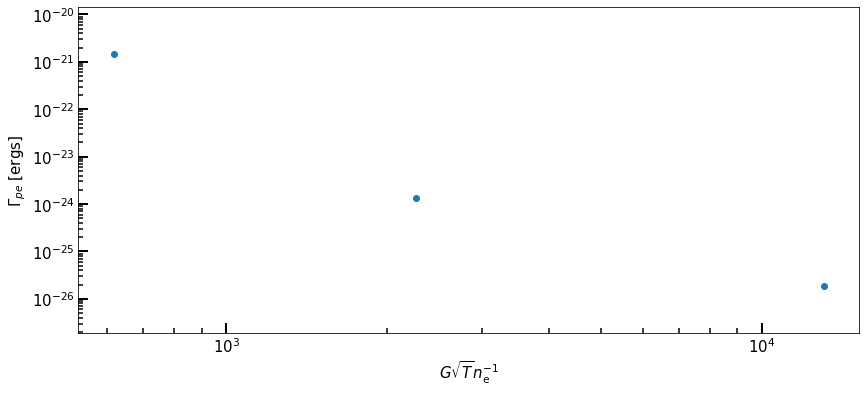

In [72]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111)

ax.scatter(GTn, Gammatot)

ax.set_yscale("log")
ax.set_xscale("log")
#
ax.set_xlabel("$G\sqrt{T}n_{\mathrm{e}}^{-1}$", fontsize=15)
ax.set_ylabel("$\Gamma_{pe}$ [ergs]", fontsize=15)

ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=15, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=15, direction="in")

ax.set_ylim(min(Gammatot)/10., max(Gammatot)*10.)

fig.show()
